In [7]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
np.random.seed(33)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error #Error a utilizar para medir rendimiento

# import sympy
# x = sympy.Symbol('x')

# Lectura de Datos

Leemos los datos para utilizarlos en la predicción de los datos

In [3]:
#Guardamos los datos de cada archivo en su variable respectiva
diabetes = None
laser = None
quake = None

columnasDiabetes = None
columnasLaser = None
columnasQuake = None

archivos = ['diabetes_normalized.dat','laser_normalized.dat','quake_normalized.dat']

for i,archivo in enumerate(archivos):
    datos = pd.read_csv('datasets/'+archivo)
    if(i == 0):
        columnasDiabetes = datos.columns[1:]
        datos = datos.drop(datos.columns[[0, -1]], axis=1)
        diabetes = datos.to_numpy()
    elif(i == 1):
        columnasLaser = datos.columns[1:]
        datos = datos.drop(datos.columns[[0, -1]], axis=1)
        laser = datos.to_numpy()
    elif(i == 2):
        columnasQuake = datos.columns[1:]
        datos = datos.drop(datos.columns[[0, -1]], axis=1)
        quake = datos.to_numpy()

In [4]:
#Guardamos los resultados reales de cada dataset
diabetes_y = None
laser_y = None
quake_y = None

archivos = ['diabetes_normalized.dat','laser_normalized.dat','quake_normalized.dat']

for i,archivo in enumerate(archivos):
    datos = pd.read_csv('datasets/'+archivo)
    datos = datos.iloc[:, -1:]
    if(i == 0):
        diabetes_y = datos.to_numpy()
    elif(i == 1):
        laser_y = datos.to_numpy()
    elif(i == 2):
        quake_y = datos.to_numpy()

# Algoritmo Genetico

1. ***CODIFICACIÓN.*** Las variables *diabetes*, *laser* y *quake*.

2. ***FUNCIÓN DE FITNESS.*** Utilizamos *mean_squared_error* de la libreria *sklearn*. Es decir, el error cuadratico medio (MSE).

In [5]:
def fitness(X,y,hiperParametros,tipo=None):
    fit = []
    for hip in hiperParametros:
        y_pred = []
        for ejemplo in X:
            y_pred.append(hip[0]+np.sum(ejemplo*hip[1:]))
        if(tipo=='mean'):
            fit.append(mean_squared_error(y,np.array(y_pred)))
    return fit

3. ***POBLACIÓN INICIAL.*** Como todos los datos estan normalizados, [0,1], creamos valores aleatorios en ese mismo rango. Tantos como numero de ejemplos, y atributos, existen en cada dataset.

_PREDECIMOS LOS HIPERPARAMETROS DE LA REGRESIÓN LINEAL_

In [6]:
def crearPoblacionInicial(dataset,n=10):
    #Creamos tantas poblaciones iniciales como ejemplos, y atributos, dentro de cada propio dataset.
    poblacion = np.array([[random.uniform(-1, 1) for _ in range(dataset.shape[1]+1)] for _ in range(n)])
    return poblacion

In [8]:
#Prueba para ver si funciona todo por ahora
poblacionDiabetes = crearPoblacionInicial(diabetes)
poblacionLaser = crearPoblacionInicial(laser)
poblacionQuake = crearPoblacionInicial(quake)

for X,y,poblacion in zip([diabetes,laser,quake],[diabetes_y,laser_y,quake_y],[poblacionDiabetes,poblacionLaser,poblacionQuake]):
    print(fitness(X,y,poblacion,"mean"))

[0.09218890302345296, 0.28153794369750873, 0.9099094316850794, 0.45310388925567885, 0.3757353664088859, 3.5873121881525027, 0.16080500832785194, 1.8132352900872049, 2.265768256761895, 0.6830846829914029]
[0.07599585493847974, 0.37248194456306183, 0.21034765151904894, 0.07207882782832592, 0.22620348479635677, 0.1418294348018511, 0.13893377191483655, 0.21657003257057944, 0.543550769376303, 1.0836827263987923]
[0.7135881955912676, 1.4346419409094058, 2.5561133729276126, 2.1357764097289427, 0.07749851853995252, 0.14477497152275542, 0.8259656097985613, 0.7134327814657163, 0.16205585556060687, 0.07768819141800706]


4. ***SELECCIÓN DE PROGENITORES.*** Seleccionamos nuevos progenitores. Tienen que tener la misma cantidad ya que son hiperparametros utilizados para predecir el valor salida de cada dataset.
Tenemos varios metodos para elegir progenitores.

In [9]:
def selProgenitores(X,y,poblacion,metodo=None,extra=None,tipoFitness=None):
    if(metodo == 'ruleta'):
        #Obtengo el fitness de la poblacion y la normalizo para tenerlos en rango [0,1]
        fit = 1/np.array(fitness(X,y,poblacion,tipoFitness))
        if(extra is not None):
            #Tratamos evitar el error de convergencia prematura (fitness muy predominante)
            if(extra == 'goldberg'):
                c = 1.5
                mean = np.mean(fit)
                std = np.std(fit)
                for i,f in enumerate(fit):
                    fit[i] = max(f-(mean-c*std),0)+0.1
            #Tratamos evitar el error de convergencia lenta (fitness similares)
            elif(extra == 'windowing'):
                #Para evitar problemas con divisiones entre 0, restamos la media de los dos peores fitness
                b = np.mean(np.sort(-fit)[:2])
                for i,f in enumerate(fit):
                    fit[i] = f-b+0.1
        #Normalizo todos los fitness
        fit /= np.sum(fit)
        
        #Creo los intervalos donde se encuentran los distintos cromosomas
        intervalos = [0]
        for valor in fit:
            intervalos.append(valor+intervalos[-1])

        #Creo tantos valores aleatorios como cromosomas hay, en un rango de [0,1]. Los que se encuentren dentro de ese intervalo son los cromosomas elegidos.
        seleccion = [np.random.rand() for _ in range(len(poblacion))]
        
        #Obtengo los indices de los cromosomas elegidos como progenitores
        indicesProgenitores = []
        for selec in seleccion:
            for i,inter in enumerate(intervalos):
                if(selec < inter):
                    indicesProgenitores.append(i)
                    break
        
        #Obtengo los progenitores mediante los indices calculados
        progenitores = []
        for indice in indicesProgenitores:
            progenitores.append(poblacion[indice-1])
        return np.array(progenitores)

    elif(metodo == 'ranking'):
        #Obtengo el fitness de la poblacion y su orden descendente
        fit = 1/np.array(fitness(X,y,poblacion,tipoFitness))
        orden = np.argsort(-fit)

        #Creo las probabilidades para cada posicion del ranking
        probabilidades = []
        total_pos = 0
        for i in range(len(fit)-1):
            if(fit[i] != fit[i+1]):
                total_pos += 1
        s = 1.5
        prob = (2-s)/len(fit)+(2*total_pos*(s-1))/(len(fit)*(len(fit)-1))
        for i in range(len(orden)-1):
            probabilidades.append(prob)
            if(fit[i] != fit[i+1]):
                total_pos -= 1
                prob = (2-s)/len(fit)+(2*total_pos*(s-1))/(len(fit)*(len(fit)-1))
        probabilidades.append(prob)
        #print(np.sum(probabilidades),len(probabilidades),probabilidades)
        
        #Creo los intervalos donde se encuentran los distintos cromosomas
        intervalos = [0]
        for valor in fit:
            intervalos.append(valor+intervalos[-1])

        #Creo tantos valores aleatorios como cromosomas hay, en un rango de [0,1]. Los que se encuentren dentro de ese intervalo son los cromosomas elegidos.
        seleccion = [np.random.rand() for _ in range(len(poblacion))]
        
        #Obtengo los indices de los cromosomas elegidos como progenitores
        indicesProgenitores = []
        for selec in seleccion:
            for i,inter in enumerate(intervalos):
                if(selec < inter):
                    indicesProgenitores.append(i)
                    break
        
        #Obtengo los progenitores mediante los indices calculados
        progenitores = []
        for indice in indicesProgenitores:
            progenitores.append(poblacion[indice-1])
        return np.array(progenitores)
    
    elif(metodo == 'torneo'):
        #Obtengo el fitness de la poblacion y su orden descendente
        fit = 1/np.array(fitness(X,y,poblacion,tipoFitness))
        
        #Cantidad de elementos en el torneo
        k = extra[1]
        
        progenitores = []
        #CON reemplazamiento (Mismo cromosoma en mismo torneo)
        if(extra[0]):
            for i in range(len(poblacion)):
                indicesAleatorios = np.random.choice(len(poblacion), k)
                progenitores.append(poblacion[np.argmax(fit[indicesAleatorios])])
        #SIN reemplazamiento (Cromosoma no puede repetir en torneo)
        else:
            for i in range(len(poblacion)):
                indicesAleatorios = np.random.choice(len(poblacion), k, replace=False)
                progenitores.append(poblacion[np.argmax(fit[indicesAleatorios])])
        return np.array(progenitores)

5. ***MÉTODO DE CRUZAMIENTO.*** Usamos una probabilidad de cruzamiento para ello, si se cumple cortamos una parte de un cromosoma e intercambiamos la misma longitud de cromosoma con otro distinto.

In [10]:
import copy

def cruzamiento(crom1, crom2, metodo=None, prob_cruz=0.95):
    #Meodo de cruzar cromosomas por un punto
    if(metodo=='unico'):
        if(np.random.rand() > prob_cruz):
            return crom1,crom2
        else:
            corte = np.random.randint(len(crom1))
            aux = copy.deepcopy(crom2[corte:])
            crom2[corte:] = crom1[corte:]
            crom1[corte:] = aux
            return crom1,crom2
    
    #Metodo de cruzar cromosomas por dos puntos
    elif(metodo=='doble'):
        if(np.random.rand() > prob_cruz):
            return crom1,crom2
        else:
            corteA = np.random.randint(len(crom1)-1)
            corteB = np.random.randint(corteA+1,len(crom1))
            aux = copy.deepcopy(crom2[corteA:corteB])
            crom2[corteA:corteB] = crom1[corteA:corteB]
            crom1[corteA:corteB] = aux
            return crom1,crom2
    
    #Metodo de cruzar los cromosomas gen por gen
    elif(metodo=='multiple'):
        for i, (gen1, gen2) in enumerate(zip(crom1, crom2)):
            if(np.random.rand() <= prob_cruz):
                aux = copy.deepcopy(crom2[i])
                crom2[i] = crom1[i]
                crom1[i] = aux
        return crom1,crom2

6. ***MÉTODO DE MUTACIÓN.*** Usamos una probabilidad de mutación para ello. A lo largo de cada miembro del cromosoma, si se cumple la condición de probabilidad, mutamos el valor del miembro del mismo en un rango determinado, [-1,1].

In [11]:
def mutacion(crom,metodo=None,prob_mut=0.01):
    #Metodo de resetear el valor completo del gen del cromosoma
    if(metodo=='reseteo'):
        cromosomaMutacion = copy.deepcopy(crom)
        for i in range(len(crom)):
            if(np.random.rand() <= prob_mut):
                cromosomaMutacion[i] = random.uniform(-1, 1)
        return cromosomaMutacion
    
    #Metodo de realizar un desplazamiento del valor del gen (sumar o restar una pequeña cantidad)
    elif(metodo=='desplazamiento'):
        cromosomaMutacion = copy.deepcopy(crom)
        for i in range(len(crom)):
            if(np.random.rand() <= prob_mut):
                desplazamiento = random.uniform(-0.15, 0.15)
                cromosomaMutacion[i] = crom[i]+desplazamiento
        return cromosomaMutacion

7. ***SELECCIÓN DE SUPERVIVIENTES O SUSTITUCIÓN.*** Selecciona los nuevos individuos de la proxima población. De manera predeterminada seleccionamos los mejores y en la misma cantidad que la población antigua.

In [12]:
def selSupervivientes(X,y,antigua,nueva,metodo=None,extra=None,tipoFitness=None):
    #Metodo de seleccion por edad. Solo se devuleven las nuevas
    if(metodo=="edad"):
        return nueva
    
    #Metodo de seleccionar los que mejores fitness devuelvan en general
    elif(metodo=="elitismo"):
        fitAntigua = np.array(fitness(X,y,antigua,tipoFitness))
        fitNueva = np.array(fitness(X,y,nueva,tipoFitness))
        fitTotal = np.append(fitAntigua,fitNueva)
        
        seleccion = np.argsort(fitTotal)[:len(antigua)]
        supervivientes = []
        for i in seleccion:
            if(i < len(antigua)):
                supervivientes.append(antigua[i])
            else:
                supervivientes.append(nueva[i-(len(antigua)-1)-1])
        return np.array(supervivientes)
    
    #Metodo de seleccionar supervivientes eliminando los k peores cromosomas antiguos y sustituyendolos por los k mejores cromosomas nuevos
    elif(metodo=="genitor"):
        fitAntigua = np.array(fitness(X,y,antigua,tipoFitness))
        fitNueva = np.array(fitness(X,y,nueva,tipoFitness))
        
        indexAntigua = np.argsort(-fitAntigua)
        indexNueva = np.argsort(-fitAntigua)

        selAntigua = antigua[indexAntigua[:len(indexAntigua)-extra]]
        selNueva = nueva[indexNueva[:extra]]
        
        supervivientes = np.concatenate((selAntigua, selNueva), axis=0)
        return supervivientes

### ***PROGRAMA PRINCIPAL DEL ALGORITMO GENÉTICO***

Al no existir una solución perfecta (error 0 en mean_squared_error), vamos ha parar el algoritmo en cuanto se llegue a un número máximo de iteraciones.

In [13]:
def algoritmoGenetico(X,y,poblacionInicial=None,prob_cruz=0.9,prob_mut=0.05,num_iteraciones=2000,tipoFitness=None,metodoProgenitores=None,extraProgenitores=None,metodoCruzamiento=None,metodoMutacion=None,realizarMutacion=None,metodoSupervivientes=None,extraSupervivientes=None):
    ## Creación porblación inicial
    if(poblacionInicial is None):
        poblacion = crearPoblacionInicial(X)
    else:
        poblacion = poblacionInicial
        
    descensoFitness = [np.min(fitness(X,y,poblacion,tipo=tipoFitness))]
    for iter in range(num_iteraciones):
        ## Selección de progenitores
        poblacion = selProgenitores(X,y,poblacion,metodoProgenitores,extraProgenitores,tipoFitness)

        ## Cruzamiento
        progenitores = []
        combinaciones = []
        indices = np.arange(0,len(poblacion),1)

        while len(indices) > 0:
            a, b = random.sample(list(indices), 2)
            combinaciones.append((poblacion[a], poblacion[b]))
            indices = np.delete(indices,np.where(indices==a))
            indices = np.delete(indices,np.where(indices==b))

        for combo in combinaciones:
            nuevo1,nuevo2 = cruzamiento(combo[0],combo[1],metodoCruzamiento,prob_cruz)
            progenitores.append(nuevo1)
            progenitores.append(nuevo2)
            
        ## Mutación
        if(realizarMutacion):
            for i in range(len(progenitores)):
                progenitores[i] = mutacion(progenitores[i],metodoMutacion,prob_mut)
        progenitores = np.array(progenitores)

        ## Selección de supervivientes
        poblacion = selSupervivientes(X,y,poblacion,progenitores,metodoSupervivientes,extraSupervivientes,tipoFitness)
        descensoFitness.append(np.min(fitness(X,y,poblacion,tipo=tipoFitness)))
        
    return poblacion,descensoFitness

# **Combinacion parametros**

- **fitness**

    1.1. **mean**

- **selProgenitores**

    2.1. Metodo **ruleta**
    
        2.1.1. Probabilidad cromosoma normal

        2.1.2. Probabilidad cromosoma goldberg

        2.1.3. Probabilidad cromosoma windowing
    
    2.2. Metodo **ranking**

    2.3. Metodo **torneo**

        2.3.1. CON Reemplazamiento

        2.3.2. SIN Reemplazamiento

- **cruzamiento**

    3.1. **unico**

    3.2. **doble**

    3.3. **multiple**

- **mutacion** (SI o NO)

    4.1. **reseteo**

    4.2. **desplazamiento**

- **selSupervivientes**

    5.1. **edad**

    5.2. **elitismo**

    5.3. **genitor**

        5.3.1. K numero cromosomas a reemplazar

In [23]:
'''
Creamos todas las iteraciones posibles
'''
iteraciones = []

for elecProg in ["ruleta","ranking","torneo"]:
    for elecCruz in ["unico","doble","multiple"]:
        for realMut in [True,False]:
            for elecSuper in ["edad","elitismo","genitor"]:
                
                if elecProg == "ruleta":
                    for prob in [None,"goldberg","windowing"]:
                        if realMut:
                            for elecMut in ["reseteo","desplazamiento"]:
                                if(elecSuper =="genitor"):
                                    iteraciones.append((elecProg,prob,elecCruz,elecMut,realMut,elecSuper,4))
                                else:
                                    iteraciones.append((elecProg,prob,elecCruz,elecMut,realMut,elecSuper,None))
                        else:
                            if(elecSuper =="genitor"):
                                iteraciones.append((elecProg,prob,elecCruz,None,realMut,elecSuper,4))
                            else:
                                iteraciones.append((elecProg,prob,elecCruz,None,realMut,elecSuper,None))
                if elecProg == "torneo":
                    for prob in [True,False]:
                        if realMut:
                            for elecMut in ["reseteo","desplazamiento"]:
                                if(elecSuper =="genitor"):
                                    iteraciones.append((elecProg,(prob,3),elecCruz,elecMut,realMut,elecSuper,4))
                                else:
                                    iteraciones.append((elecProg,(prob,3),elecCruz,elecMut,realMut,elecSuper,None))
                        else:
                            if(elecSuper =="genitor"):
                                iteraciones.append((elecProg,(prob,3),elecCruz,None,realMut,elecSuper,4))
                            else:
                                iteraciones.append((elecProg,(prob,3),elecCruz,None,realMut,elecSuper,None))
                else:
                    if realMut:
                        for elecMut in ["reseteo","desplazamiento"]:
                            if(elecSuper =="genitor"):
                                iteraciones.append((elecProg,None,elecCruz,elecMut,realMut,elecSuper,4))
                            else:
                                iteraciones.append((elecProg,None,elecCruz,elecMut,realMut,elecSuper,None))
                    else:
                        if(elecSuper =="genitor"):
                            iteraciones.append((elecProg,None,elecCruz,None,realMut,elecSuper,4))
                        else:
                            iteraciones.append((elecProg,None,elecCruz,None,realMut,elecSuper,None))

# **Problemas a evaluar**

Vamos a probar todas las distintas iteraciones en el algoritmo y guardamos los resultados sobre el dataset **Diabetes**

In [17]:
'''
Creamos un DataFrame donde se guarden los resultados de cada iteracion

Celda comentada ya que para realizar el algoritmo hay numeros aleatorios y una segunda ejecución afectaría cambiando los resultados
'''
# X = diabetes
# y = diabetes_y
# resultadosMean = pd.DataFrame(columns=iteraciones,index=["Mejor Cromosoma", "Mejor Fitness"])
# poblacionInicial = crearPoblacionInicial(X)

# for i,iter in enumerate(iteraciones):
#     poblacion = algoritmoGenetico(X,y,poblacionInicial=poblacionInicial,num_iteraciones=1000,tipoFitness='mean',metodoProgenitores=iter[0],extraProgenitores=iter[1],metodoCruzamiento=iter[2],metodoMutacion=iter[3],realizarMutacion=iter[4],metodoSupervivientes=iter[5],extraSupervivientes=iter[6])
#     fitnes = fitness(X,y,poblacion,'mean')
#     resultadosMean.iloc[1,i] = np.min(fitnes)
#     resultadosMean.iloc[0,i] = poblacion[np.argmin(fitnes)]
# resultadosMean

,"(ruleta, None, unico, reseteo, True, edad, None)","(ruleta, None, unico, desplazamiento, True, edad, None)","(ruleta, goldberg, unico, reseteo, True, edad, None)","(ruleta, goldberg, unico, desplazamiento, True, edad, None)","(ruleta, windowing, unico, reseteo, True, edad, None)","(ruleta, windowing, unico, desplazamiento, True, edad, None)","(ruleta, None, unico, reseteo, True, edad, None)","(ruleta, None, unico, desplazamiento, True, edad, None)","(ruleta, None, unico, reseteo, True, elitismo, None)","(ruleta, None, unico, desplazamiento, True, elitismo, None)","(ruleta, goldberg, unico, reseteo, True, elitismo, None)","(ruleta, goldberg, unico, desplazamiento, True, elitismo, None)","(ruleta, windowing, unico, reseteo, True, elitismo, None)","(ruleta, windowing, unico, desplazamiento, True, elitismo, None)","(ruleta, None, unico, reseteo, True, elitismo, None)","(ruleta, None, unico, desplazamiento, True, elitismo, None)","(ruleta, None, unico, reseteo, True, genitor, 4)","(ruleta, None, unico, desplazamiento, True, genitor, 4)","(ruleta, goldberg, unico, reseteo, True, genitor, 4)","(ruleta, goldberg, unico, desplazamiento, True, genitor, 4)","(ruleta, windowing, unico, reseteo, True, genitor, 4)","(ruleta, windowing, unico, desplazamiento, True, genitor, 4)","(ruleta, None, unico, reseteo, True, genitor, 4)","(ruleta, None, unico, desplazamiento, True, genitor, 4)","(ruleta, None, unico, None, False, edad, None)","(ruleta, goldberg, unico, None, False, edad, None)","(ruleta, windowing, unico, None, False, edad, None)","(ruleta, None, unico, None, False, edad, None)","(ruleta, None, unico, None, False, elitismo, None)","(ruleta, goldberg, unico, None, False, elitismo, None)","(ruleta, windowing, unico, None, False, elitismo, None)","(ruleta, None, unico, None, False, elitismo, None)","(ruleta, None, unico, None, False, genitor, 4)","(ruleta, goldberg, unico, None, False, genitor, 4)","(ruleta, windowing, unico, None, False, genitor, 4)","(ruleta, None, unico, None, False, genitor, 4)","(ruleta, None, doble, reseteo, True, edad, None)","(ruleta, None, doble, desplazamiento, True, edad, None)","(ruleta, goldberg, doble, reseteo, True, edad, None)","(ruleta, goldberg, doble, desplazamiento, True, edad, None)","(ruleta, windowing, doble, reseteo, True, edad, None)","(ruleta, windowing, doble, desplazamiento, True, edad, None)","(ruleta, None, doble, reseteo, True, edad, None)","(ruleta, None, doble, desplazamiento, True, edad, None)","(ruleta, None, doble, reseteo, True, elitismo, None)","(ruleta, None, doble, desplazamiento, True, elitismo, None)","(ruleta, goldberg, doble, reseteo, True, elitismo, None)","(ruleta, goldberg, doble, desplazamiento, True, elitismo, None)","(ruleta, windowing, doble, reseteo, True, elitismo, None)","(ruleta, windowing, doble, desplazamiento, True, elitismo, None)","(ruleta, None, doble, reseteo, True, elitismo, None)","(ruleta, None, doble, desplazamiento, True, elitismo, None)","(ruleta, None, doble, reseteo, True, genitor, 4)","(ruleta, None, doble, desplazamiento, True, genitor, 4)","(ruleta, goldberg, doble, reseteo, True, genitor, 4)","(ruleta, goldberg, doble, desplazamiento, True, genitor, 4)","(ruleta, windowing, doble, reseteo, True, genitor, 4)","(ruleta, windowing, doble, desplazamiento, True, genitor, 4)","(ruleta, None, doble, reseteo, True, genitor, 4)","(ruleta, None, doble, desplazamiento, True, genitor, 4)","(ruleta, None, doble, None, False, edad, None)","(ruleta, goldberg, doble, None, False, edad, None)","(ruleta, windowing, doble, None, False, edad, None)","(ruleta, None, doble, None, False, edad, None)","(ruleta, None, doble, None, False, elitismo, None)","(ruleta, goldberg, doble, None, False, elitismo, None)","(ruleta, windowing, doble, None, False, elitismo, None)","(ruleta, None, doble, None, False, elitismo, None)","(ruleta, None, doble, None, False, genitor, 4)","(ruleta, goldberg, doble, None, False, genitor, 4)","(ruleta, windowing, doble, None, False, genitor, 4)

In [21]:
'''
Array de resultados obtenidos anteriormente
'''
array_numeros = [0.026871, 0.030309, 0.028028, 0.024787, 0.046714, 0.041442, 0.029864, 0.025281, 0.02528, 0.025925, 0.026274, 0.025431, 0.039298, 0.024859, 0.029373, 0.025331, 0.056188, 31.441874, 0.071353, 0.032786, 0.743722, 43.070832, 0.100209, 23.981891, 0.088069, 0.053575, 0.039275, 0.112598, 0.053575, 0.088069, 0.086094, 0.07652, 0.156545, 3.824536, 1.664979, 0.191279, 0.026644, 0.026425, 0.026554, 0.024756, 0.102416, 0.033616, 0.025137, 0.024956, 0.027896, 0.024809, 0.025789, 0.024767, 0.026819, 0.024871, 0.026907, 0.025186, 0.045266, 14.395921, 0.089304, 0.033762, 6.113663, 52.388028, 0.109152, 31.983714, 0.077105, 0.056965, 0.069849, 0.07687, 0.088069, 0.07652, 0.074509, 0.080036, 0.264744, 0.113324, 0.374602, 0.076598, 0.026999, 0.02671, 0.025544, 0.02496, 0.031851, 0.027616, 0.031053, 0.027851, 0.02795, 0.025153, 0.029998, 0.024852, 0.030023, 0.024762, 0.027479, 0.024746, 0.049835, 29.353411, 0.094531, 0.027982, 0.34735, 42.694315, 0.053606, 26.614694, 0.088069, 0.088069, 0.087996, 0.088069, 0.053575, 0.088069, 0.098988, 0.039275, 0.110998, 0.191279, 3.068421, 0.133161, 0.255663, 0.32754, 0.027181, 0.024727, 0.191279, 0.191279, 0.191279, 0.191279, 0.191279, 0.116215, 0.28057, 0.025988, 0.024767, 0.191279, 0.166323, 0.191279, 0.191279, 0.191279, 0.778751, 0.129725, 0.025313, 0.024767, 0.191279, 0.191279, 0.191279, 0.191279, 0.191279, 2.968442, 0.103352, 0.084889, 3.141143, 0.028975, 0.024846, 0.028765, 0.024842, 1.531849, 1.531849, 1.835518, 1.396333, 0.191279, 0.258886, 0.128419, 0.128419, 1.835518, 1.531849, 0.058184, 1.703895, 0.940022, 0.067816, 0.027617, 0.024753, 0.026436, 0.024735, 0.164673, 1.835518, 1.472733, 1.530203, 0.330241, 1.060715, 0.073098, 0.203818, 1.531849, 1.835518, 0.137219, 0.572134, 0.070301, 1.707843, 0.031461, 0.024763, 0.026341, 0.024751, 0.409293, 1.531849, 1.531849, 1.531849, 1.2027, 0.191279, 0.191279, 0.191279, 1.531849, 1.531849]

(57, 0.024727, 189)

In [83]:
'''
Bucle donde incluyo las iteraciones a probar para las modificaciones
'''
iteraciones_puebas = []
for i in [160]:
    iteraciones_puebas.append(iteraciones[i])

In [39]:
'''
Bucle para crear las distintas modificaciones de MUTACIONES dentro del algoritmo en distintos conjuntos de elementos
'''
# X = diabetes
# y = diabetes_y
# poblacionInicial = crearPoblacionInicial(X)
# cambiosMutacion = []
# for i,iter in enumerate(iteraciones_puebas):
#     cambiosMutacion.append([])
#     for prob in [0,0.01,0.05,0.1,0.2,0.5,0.8,1]:
#         poblacion = algoritmoGenetico(X,y,prob_mut=prob,poblacionInicial=poblacionInicial,num_iteraciones=1000,tipoFitness='mean',metodoProgenitores=iter[0],extraProgenitores=iter[1],metodoCruzamiento=iter[2],metodoMutacion=iter[3],realizarMutacion=iter[4],metodoSupervivientes=iter[5],extraSupervivientes=iter[6])
#         fitnes = fitness(X,y,poblacion,'mean')
#         cambiosMutacion[i].append(np.min(fitnes))

In [1]:
cambiosMutacion = [[0.18471703149494942,
  0.02619069415259571,
  0.02497484322498342,
  0.024751831973425613,
  0.024717981165649886,
  0.024714454156753676,
  0.024720396409348415,
  0.02472196307855367],
 [0.07998584832825881,
  0.027350274009929062,
  0.024727517580042706,
  0.024732624048992288,
  0.024713367521626714,
  0.024719475575892887,
  0.024715330451783597,
  0.024720629742443],
 [0.060224843178459185,
  0.03403148620127021,
  0.02484936954181597,
  0.024775438244551518,
  0.024717731306484223,
  0.024716620715849683,
  0.02472753900936486,
  0.024928069779273428],
 [0.09527601553486204,
  0.031669967294721615,
  0.024932100145342796,
  0.024717421660099097,
  0.024714632545018593,
  0.024715732339745493,
  0.024713408538255623,
  0.024717282454815002],
 [0.06852578226901025,
  0.028052033040948506,
  0.024720511411687834,
  0.02471462077393237,
  0.024714464536011796,
  0.024715132215831607,
  0.024714842042763707,
  0.0247337339100383]]

In [4]:
np.min(cambiosMutacion)

0.024713367521626714

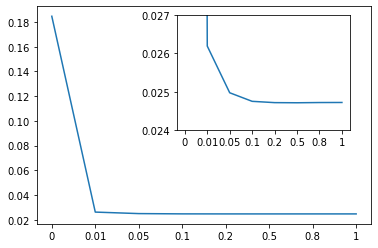

In [30]:
'''
Grafica para visualizar los cambios en MUTACION
'''
plt.plot(cambiosMutacion[0])
plt.xticks(range(len([0,0.01,0.05,0.1,0.2,0.5,0.8,1])), [0,0.01,0.05,0.1,0.2,0.5,0.8,1])

# Crear un segundo conjunto de ejes para la segunda gráfica
ax = plt.axes([0.45, 0.45, 0.4, 0.4])  # [left, bottom, width, height]

# Graficar la segunda gráfica en los nuevos ejes
ax.plot(cambiosMutacion[0])
ax.set_ylim(0.024, 0.027)
ax.set_xticks(range(len([0,0.01,0.05,0.1,0.2,0.5,0.8,1])))
ax.set_xticklabels([0,0.01,0.05,0.1,0.2,0.5,0.8,1])

plt.show()

In [52]:
'''
Bucle para crear las distintas modificaciones de TORNEO dentro del algoritmo en distintos conjuntos de elementos
'''
# X = diabetes
# y = diabetes_y
# poblacionInicial = crearPoblacionInicial(X)
# cambiosTorneoTRUE = []
# cambiosTorneoFALSE = []
# for i,iter in enumerate(iteraciones_puebas):
#     cambiosTorneoTRUE.append([])
#     cambiosTorneoFALSE.append([])
#     for k in [2,3,5]:
#         for j,reemplazo in enumerate([True,False]):
#             poblacion = algoritmoGenetico(X,y,poblacionInicial=poblacionInicial,num_iteraciones=1000,tipoFitness='mean',metodoProgenitores=iter[0],extraProgenitores=(reemplazo,k),metodoCruzamiento=iter[2],metodoMutacion=iter[3],realizarMutacion=iter[4],metodoSupervivientes=iter[5],extraSupervivientes=iter[6])
#             fitnes = fitness(X,y,poblacion,'mean')
#             if(reemplazo):
#                 cambiosTorneoTRUE[i].append(np.min(fitnes))
#             else:
#                 cambiosTorneoFALSE[i].append(np.min(fitnes))

In [ ]:
np.min(cambiosTorneoFALSE),np.min(cambiosTorneoTRUE)
# (0.02472039223149006, 0.02471736865082236)

In [86]:
'''
Mejor combinación de hiper-parametros si modificamos MUTACION como TORNEO
'''
# iteraciones_puebas = []
# for i in [160]:
#     iteraciones_puebas.append(iteraciones[i])

# poblacion = algoritmoGenetico(X,y,prob_mut=0.2,poblacionInicial=poblacionInicial,num_iteraciones=1000,tipoFitness='mean',metodoProgenitores=iteraciones_puebas[0][0],extraProgenitores=iteraciones_puebas[0][1],metodoCruzamiento=iteraciones_puebas[0][2],metodoMutacion=iteraciones_puebas[0][3],realizarMutacion=iteraciones_puebas[0][4],metodoSupervivientes=iteraciones_puebas[0][5],extraSupervivientes=iteraciones_puebas[0][6])
# fitnes = fitness(X,y,poblacion,'mean')
# np.min(fitnes)

<function __main__.fitness(X, y, hiperParametros, tipo=None)>

In [67]:
fitness = [0.024714815757664675,
 0.024714815757664675,
 0.024714815757664675,
 0.024714815757664675,
 0.024714815757664675,
 0.024714815757664675,
 0.024714815757664675,
 0.024714815757664675,
 0.024714815757664675,
 0.024714815757664675]

In [103]:
'''
Bucle para crear las distintas modificaciones de NUMERO CROMOSOMAS POBLACIÓN INICIAL dentro del algoritmo en distintos conjuntos de elementos
'''
# X = diabetes
# y = diabetes_y
# cambiosPoblacionInicial = []
# for i,pob in enumerate([3,5,10,15,20]):
#     poblacionInicial = crearPoblacionInicial(X,pob)
#     poblacion = algoritmoGenetico(X,y,prob_mut=0.2,poblacionInicial=poblacionInicial,num_iteraciones=1000,tipoFitness='mean',metodoProgenitores=iter[0],extraProgenitores=iter[1],metodoCruzamiento=iter[2],metodoMutacion=iter[3],realizarMutacion=iter[4],metodoSupervivientes=iter[5],extraSupervivientes=iter[6])
#     fitnes = fitness(X,y,poblacion,'mean')
#     cambiosPoblacionInicial.append(np.min(fitnes))

In [105]:
cambiosPoblacionInicial = [0.024719636761249834,
 0.024726443292594772,
 0.024713544020639192,
 0.02471697083893457,
 0.024713528377747564]

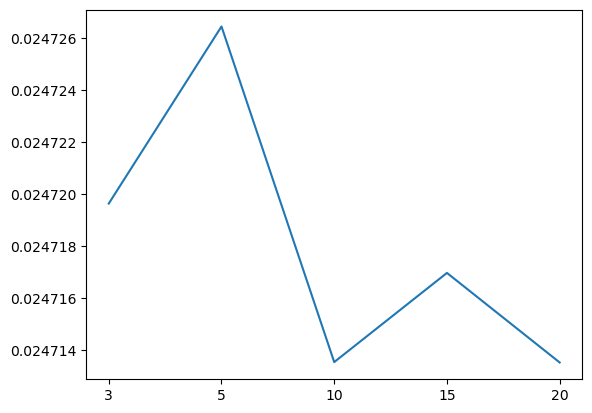

In [109]:
'''
Grafica para visualizar los CAMBIOS DE POBLACION INICIAL
'''
row = [3,5,10,15,20]
plt.plot(cambiosPoblacionInicial)
plt.xticks(np.arange(len(row)), row)
plt.show()

# **Problemas a evaluar resto datasets**

Una vez averiguados los resultados de las mejores y peores combinaciones, vamos a probar estos resultados en los demas datasets

In [110]:
'''
Función para crear las graficas de comparación de resultados con el algoritmo genético y scikit-learn
'''
def compararResultadosConScikit(X,y,cromosoma,nombreColumnas):
    # Crea 10 puntos para la primera dimensión (B0) entre 0 y 1
    B0 = np.linspace(0, 1, 10)
    # Crea 7 puntos para la segunda dimensión (B1) entre 0 y 1
    B1 = np.linspace(0, 1, 10)

    # Crear todas las combinaciones de los puntos creados anteriormente usando meshgrid (guardar en xx, yy)
    xx, yy = np.meshgrid(B0, B1, indexing='xy')

    # Crea una matriz Xtest que contenga todos los valores de xx en la primera columna y los de yy en la segunda
    # Utiliza la función hstack y para para ello previamente tendras que darles la forma correspondiente a xx e yy (reshape)
    Xtest = np.hstack((xx.reshape(-1,1),yy.reshape(-1,1)))

    # Utiliza predict para obtener los valores de Z (el plano) - luego hacemos un reshape (al shape de xx) para poder pintarlo
    lr = LinearRegression().fit(X,y)
    Z = lr.predict(Xtest)
    Z = Z.reshape(xx.shape)
    
    # Calcular la posición de cada punto respecto al plano
    y_pred = lr.predict(X)
    aux = []
    for i in range(len(y)):
        aux.append(y[i]-y_pred[i])
    posicionesScikit = np.sign(aux)

    # Calculo la predicción con los pesos del cromosoma obtenido por el genético
    lr.coef_ = cromosoma[1:]
    Z2 = lr.predict(Xtest)
    Z2 = Z2.reshape(xx.shape)
    
    # Calcular la posición de cada punto respecto al plano
    y_pred = lr.predict(X)
    aux = []
    for i in range(len(y)):
        aux.append(y[i]-y_pred[i])
    posicionesGenetico = np.sign(aux)

    # Pintamos las dos gráficas
    fig = plt.figure(figsize=(20,12))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    # Utiliza scatter para pintar los puntos y luego plot_surface para pintar el plano de scikit-learn
    ax1.scatter(X[:,0][[posicionesScikit == 1][0].flatten()], X[:,1][[posicionesScikit == 1][0].flatten()], y[posicionesScikit == 1], c='r')
    ax1.scatter(X[:,0][[posicionesScikit == -1][0].flatten()], X[:,1][[posicionesScikit == -1][0].flatten()], y[posicionesScikit == -1], c='b')
    ax1.plot_surface(xx,yy,Z,alpha = 0.4)
    ax1.set_title('Plano obtenido por scikit-learn')
    ax1.legend(['Arriba plano','Debajo plano'])
    
    # Utiliza scatter para pintar los puntos y luego plot_surface para pintar el plano de nuestro descenso por gradiente
    ax2.scatter(X[:,0][[posicionesGenetico == 1][0].flatten()], X[:,1][[posicionesGenetico == 1][0].flatten()], y[posicionesGenetico == 1], c='r')
    ax2.scatter(X[:,0][[posicionesGenetico == -1][0].flatten()], X[:,1][[posicionesGenetico == -1][0].flatten()], y[posicionesGenetico == -1], c='b')
    ax2.plot_surface(xx,yy,Z2,alpha = 0.4)
    ax2.set_title('Plano obtenido por algoritmo genetico')
    ax2.legend(['Arriba plano','Debajo plano'])
    

    # Pon a las dos figuras las etiquetas de cada dimensión (set_xlabel...)
    for ax in fig.axes:
        ax.set_xlabel(nombreColumnas[0])
        ax.set_ylabel(nombreColumnas[1])
        ax.set_zlabel(nombreColumnas[2])
        
    plt.show()

In [15]:
'''
Guardamos la mejor y peor combinación de hiper-parametros
'''
iterBest = ('torneo', (False, 3), 'doble', 'desplazamiento', True, 'elitismo', None)
iterWorst = ('ruleta', 'windowing', 'doble', 'desplazamiento', True, 'genitor', 4)

In [17]:
'''
Calculamos los mejores y peores fitness de acuerdo con lo realizado anteriormente
'''
# X = laser
# y = laser_y
# poblacionInicial = crearPoblacionInicial(X,10)
# poblacion,descensoFitnessLaser = algoritmoGenetico(X,y,prob_mut=0.2,poblacionInicial=poblacionInicial,num_iteraciones=1000,tipoFitness='mean',metodoProgenitores=iterBest[0],extraProgenitores=iterBest[1],metodoCruzamiento=iterBest[2],metodoMutacion=iterBest[3],realizarMutacion=iterBest[4],metodoSupervivientes=iterBest[5],extraSupervivientes=iterBest[6])
# fitnes = fitness(X,y,poblacion,'mean')
# poblacionMALA,sdfsdfd = algoritmoGenetico(X,y,poblacionInicial=poblacionInicial,num_iteraciones=1000,tipoFitness='mean',metodoProgenitores=iterWorst[0],extraProgenitores=iterWorst[1],metodoCruzamiento=iterWorst[2],metodoMutacion=iterWorst[3],realizarMutacion=iterWorst[4],metodoSupervivientes=iterWorst[5],extraSupervivientes=iterWorst[6])
# fitnesMALA = fitness(X,y,poblacionMALA,'mean')

In [161]:
descensoFitnessDiabetes = [0.050176749483063735,
 0.24149877022932556,
 0.1664561737618424,
 0.11275674350075654,
 0.08953512516804309,
 0.07845058422856482,
 0.07711712896649794,
 0.07702439710476942,
 0.07512332379222518,
 0.07281790001729029,
 0.0666325066702104,
 0.06569166734502219,
 0.06569166734502219,
 0.06569166734502219,
 0.06442082951242548,
 0.06336707873292244,
 0.062429233472073055,
 0.05918825747670649,
 0.05918825747670649,
 0.05796681583375273,
 0.05796681583375273,
 0.05700480622894781,
 0.05431699074237846,
 0.05431699074237846,
 0.05431699074237846,
 0.050380873325938255,
 0.050380873325938255,
 0.04845125546908315,
 0.04845125546908315,
 0.043272070429395175,
 0.042635868207189204,
 0.03950632283338369,
 0.03950632283338369,
 0.03950632283338369,
 0.0389998877447594,
 0.0389998877447594,
 0.0389998877447594,
 0.038831228025426455,
 0.038831228025426455,
 0.038831228025426455,
 0.03615208425120862,
 0.03615208425120862,
 0.03615208425120862,
 0.03615208425120862,
 0.03615208425120862,
 0.0358926989836917,
 0.0350577521089643,
 0.0350577521089643,
 0.035057441630910804,
 0.0335199187359688,
 0.03113585220378504,
 0.03113585220378504,
 0.030792132684194482,
 0.030792132684194482,
 0.027053166526195684,
 0.027006540160010205,
 0.026952143351592003,
 0.026952143351592003,
 0.026952143351592003,
 0.026950029653583826,
 0.026950029653583826,
 0.026950029653583826,
 0.026950029653583826,
 0.026950029653583826,
 0.02658583578146436,
 0.0251615519649452,
 0.0251615519649452,
 0.024797533790750944,
 0.024797533790750944,
 0.024797533790750944,
 0.024797533790750944,
 0.024797533790750944,
 0.024797533790750944,
 0.02473800567576462,
 0.02473800567576462,
 0.02473800567576462,
 0.02473800567576462,
 0.02473800567576462,
 0.02473800567576462,
 0.02473800567576462,
 0.02473800567576462,
 0.02473800567576462,
 0.02473800567576462,
 0.02473800567576462,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.024722811347031956,
 0.02472126323026969,
 0.02472076832310074,
 0.02472076832310074,
 0.02472076832310074,
 0.02472076832310074,
 0.02472076832310074,
 0.02472076832310074,
 0.02472076832310074,
 0.02472076832310074,
 0.02472076832310074,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471803701860346,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.02471760702497986,
 0.024717554803845524,
 0.024717554803845524,
 0.024717554803845524,
 0.024717554803845524,
 0.024717554803845524,
 0.024717554803845524,
 0.024717554803845524,
 0.024717554803845524,
 0.024717554803845524,
 0.024717554803845524,
 0.024717489235766256,
 0.024717489235766256,
 0.024717489235766256,
 0.024717489235766256,
 0.024717489235766256,
 0.024717489235766256,
 0.024717489235766256,
 0.024717489235766256,
 0.024717489235766256,
 0.024717489235766256,
 0.024717489235766256,
 0.024717489235766256,
 0.024717489235766256,
 0.024717489235766256,
 0.024717489235766256,
 0.024717489235766256,
 0.024717489235766256,
 0.024717489235766256,
 0.024717489235766256,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.02471656739751067,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.0247161397172232,
 0.02471612796108108,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024715588649085168,
 0.024714810350629387,
 0.02471429917645584,
 0.02471429917645584,
 0.02471429917645584,
 0.02471429917645584,
 0.02471429917645584,
 0.02471429917645584,
 0.02471429917645584,
 0.02471429917645584,
 0.02471429917645584,
 0.02471429917645584,
 0.02471429917645584,
 0.02471429917645584,
 0.02471429917645584,
 0.02471429917645584,
 0.02471429917645584,
 0.02471429917645584,
 0.02471429917645584,
 0.02471429917645584,
 0.02471429917645584,
 0.02471429917645584,
 0.02471429917645584,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.02471398550199301,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 0.024713972286194364,
 ...]

In [164]:
poblacionDiabetesBest = np.array([0.09740722, 0.2694222 , 0.32930602])

In [175]:
descensoFitnessQuake = [0.09973604194340091,
 0.0815199630815744,
 0.07975085079596013,
 0.07857973757476262,
 0.06634269210102955,
 0.06634269210102955,
 0.06355286782568427,
 0.06294003316358192,
 0.06050103685220593,
 0.06005726783454515,
 0.052825768459840314,
 0.04827126190525525,
 0.04648345298425623,
 0.04147033957847978,
 0.04025626402121905,
 0.03890090714349756,
 0.038538124288133996,
 0.038538124288133996,
 0.03815602050672158,
 0.03815602050672158,
 0.03543822467852429,
 0.03322701583220136,
 0.03284792011857992,
 0.03284792011857992,
 0.03284792011857992,
 0.03284792011857992,
 0.032637415464950074,
 0.032540917117148606,
 0.031947016067314135,
 0.031947016067314135,
 0.031947016067314135,
 0.03154637542589905,
 0.03154637542589905,
 0.03154637542589905,
 0.03154637542589905,
 0.0309427151341198,
 0.030046641060182372,
 0.030046641060182372,
 0.029950844200051636,
 0.029950844200051636,
 0.029950844200051636,
 0.029950844200051636,
 0.029950844200051636,
 0.029950844200051636,
 0.029950844200051636,
 0.029864123245127952,
 0.029864123245127952,
 0.029864123245127952,
 0.029864123245127952,
 0.029807248216527655,
 0.029805807338407618,
 0.029805807338407618,
 0.029805807338407618,
 0.029805807338407618,
 0.029805807338407618,
 0.029805807338407618,
 0.029759659703394264,
 0.029759659703394264,
 0.029759659703394264,
 0.029759659703394264,
 0.029759659703394264,
 0.029759659703394264,
 0.029759659703394264,
 0.029759659703394264,
 0.029759659703394264,
 0.029753362494815416,
 0.029753362494815416,
 0.02973531681410192,
 0.029714600774306717,
 0.029714600774306717,
 0.029714600774306717,
 0.029714600774306717,
 0.029714600774306717,
 0.029714600774306717,
 0.029714600774306717,
 0.029714600774306717,
 0.029714600774306717,
 0.029714600774306717,
 0.029714600774306717,
 0.02971065306082753,
 0.02971065306082753,
 0.02971065306082753,
 0.02971065306082753,
 0.02971065306082753,
 0.02971065306082753,
 0.02971065306082753,
 0.02971065306082753,
 0.02971065306082753,
 0.02971065306082753,
 0.029693325811867295,
 0.029693325811867295,
 0.029683451667712045,
 0.029683451667712045,
 0.029683451667712045,
 0.029659770417538565,
 0.029659770417538565,
 0.029659770417538565,
 0.029659770417538565,
 0.029659770417538565,
 0.029659770417538565,
 0.029657810757920327,
 0.02962614401588199,
 0.02962614401588199,
 0.02962614401588199,
 0.02962614401588199,
 0.02962614401588199,
 0.02962614401588199,
 0.02962614401588199,
 0.02962614401588199,
 0.02962614401588199,
 0.02962614401588199,
 0.029594109757046547,
 0.029594109757046547,
 0.029594109757046547,
 0.029594109757046547,
 0.029594109757046547,
 0.029594109757046547,
 0.029594109757046547,
 0.029594109757046547,
 0.029594109757046547,
 0.029594109757046547,
 0.029594109757046547,
 0.029570251058914657,
 0.029570251058914657,
 0.029570251058914657,
 0.029570251058914657,
 0.02956904666857104,
 0.02956904666857104,
 0.02956904666857104,
 0.02956904666857104,
 0.02956904666857104,
 0.02956904666857104,
 0.02956904666857104,
 0.02956904666857104,
 0.02956904666857104,
 0.02956904666857104,
 0.02956904666857104,
 0.02956904666857104,
 0.02956904666857104,
 0.029568182771005327,
 0.029568182771005327,
 0.029568182771005327,
 0.029568182771005327,
 0.029568182771005327,
 0.029568182771005327,
 0.029568182771005327,
 0.029568182771005327,
 0.029568182771005327,
 0.02956731432604999,
 0.02956731432604999,
 0.02956731432604999,
 0.029554992529248692,
 0.029554992529248692,
 0.029554992529248692,
 0.029554992529248692,
 0.029553699677434646,
 0.029553699677434646,
 0.029553699677434646,
 0.029553699677434646,
 0.029553699677434646,
 0.029527330914726896,
 0.029527330914726896,
 0.029527330914726896,
 0.029527330914726896,
 0.029527330914726896,
 0.029527330914726896,
 0.029527330914726896,
 0.029527330914726896,
 0.029527330914726896,
 0.029527330914726896,
 0.029527330914726896,
 0.029527330914726896,
 0.029527330914726896,
 0.029527330914726896,
 0.029527330914726896,
 0.029527330914726896,
 0.029527330914726896,
 0.029527330914726896,
 0.029527330914726896,
 0.029527330914726896,
 0.02952708928667961,
 0.02952708928667961,
 0.02952708928667961,
 0.02952708928667961,
 0.02952708928667961,
 0.02952708928667961,
 0.02952708928667961,
 0.02952708928667961,
 0.02952708928667961,
 0.02952708928667961,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.029522794604039688,
 0.02952268017824687,
 0.02952268017824687,
 0.02952268017824687,
 0.02952268017824687,
 0.02952268017824687,
 0.02952268017824687,
 0.02952022262349968,
 0.02952022262349968,
 0.02952022262349968,
 0.02952022262349968,
 0.02952022262349968,
 0.02952022262349968,
 0.02952022262349968,
 0.02952022262349968,
 0.02952022262349968,
 0.02952022262349968,
 0.029517733480692886,
 0.029517733480692886,
 0.029517733480692886,
 0.029517733480692886,
 0.029517733480692886,
 0.029517733480692886,
 0.029517467371699344,
 0.029517467371699344,
 0.029517467371699344,
 0.029517467371699344,
 0.029517212050051356,
 0.029517212050051356,
 0.029517212050051356,
 0.029517212050051356,
 0.029517212050051356,
 0.029517212050051356,
 0.029517212050051356,
 0.029517212050051356,
 0.02951622531715687,
 0.02951622531715687,
 0.02951622531715687,
 0.02951622531715687,
 0.02951622531715687,
 0.02951622531715687,
 0.02951622531715687,
 0.02951622531715687,
 0.02951622531715687,
 0.02951622531715687,
 0.02951622531715687,
 0.02951622531715687,
 0.02951622531715687,
 0.029514721272002945,
 0.029514721272002945,
 0.029514721272002945,
 0.029514721272002945,
 0.029514721272002945,
 0.029514721272002945,
 0.029514721272002945,
 0.029514721272002945,
 0.029514721272002945,
 0.029514721272002945,
 0.029514721272002945,
 0.029514721272002945,
 0.029514721272002945,
 0.029514721272002945,
 0.029514721272002945,
 0.029514721272002945,
 0.029514721272002945,
 0.029513536635442376,
 0.029513536635442376,
 0.029513536635442376,
 0.029505904078858884,
 0.029505904078858884,
 0.029505904078858884,
 0.029505904078858884,
 0.029505904078858884,
 0.029505904078858884,
 0.029505904078858884,
 0.029505904078858884,
 0.029505904078858884,
 0.029505904078858884,
 0.029505904078858884,
 0.029505904078858884,
 0.029505904078858884,
 0.029505904078858884,
 0.029505904078858884,
 0.029505904078858884,
 0.029505904078858884,
 0.029505904078858884,
 0.029505904078858884,
 0.029505904078858884,
 0.029505904078858884,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502340540621327,
 0.029502285096725662,
 0.029502285096725662,
 0.029502285096725662,
 0.029502285096725662,
 0.029502285096725662,
 0.029502285096725662,
 0.029502285096725662,
 0.029502285096725662,
 0.029502285096725662,
 0.029502285096725662,
 0.029502285096725662,
 0.02949482368340504,
 0.02949482368340504,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.02949394667083779,
 0.029493744680378242,
 0.029493744680378242,
 0.029493744680378242,
 0.029479763368065067,
 0.029479760005297027,
 0.029479760005297027,
 0.029479760005297027,
 0.029479760005297027,
 0.029479760005297027,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947932682976582,
 0.02947919788927464,
 0.02947919788927464,
 0.02947919788927464,
 0.02947919788927464,
 0.02947919788927464,
 0.02947919788927464,
 0.02947919788927464,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.02947902735578118,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478530672850847,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.029478525241722113,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.02947805984644241,
 0.029477982781446112,
 0.029477982781446112,
 0.029477982781446112,
 0.029477982781446112,
 0.029477982781446112,
 0.029477982781446112,
 0.029477982781446112,
 0.029477982781446112,
 0.029477982781446112,
 0.029477982781446112,
 0.029477982781446112,
 0.029477982781446112,
 0.029477982781446112,
 0.029477982781446112,
 0.029477982781446112,
 0.029477982781446112,
 0.029477982781446112,
 0.029477982781446112,
 0.029477982781446112,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.02947776143277415,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 0.029477630037945374,
 ...]

In [178]:
poblacionQuakeBest = np.array([ 0.13023314,  0.00481862,  0.07226118, -0.0129432 ])

In [24]:
descensoFitnessLaser = [0.0432076198055724,
 0.10122916358881597,
 0.09887887076702875,
 0.07857778981595877,
 0.07280577335496345,
 0.06634126477185232,
 0.06259779651635297,
 0.06259779651635297,
 0.057611980796546225,
 0.05569558622693357,
 0.05336608075676466,
 0.05243251727767931,
 0.046163434781472175,
 0.0380286805619831,
 0.037962201071642485,
 0.03709019966741477,
 0.033372301598051435,
 0.03262808211655385,
 0.02910963750724763,
 0.028839816092050816,
 0.02864664865962464,
 0.026206890565741787,
 0.022833993199221806,
 0.021393483296764465,
 0.018971415301868737,
 0.01558486113857144,
 0.011871637084946905,
 0.010908138829120883,
 0.010769495203648716,
 0.010162254769184004,
 0.009620902176398447,
 0.00953343619734481,
 0.009489821397181493,
 0.008953069852374195,
 0.00868320025738206,
 0.00868320025738206,
 0.008522870390097855,
 0.008386690580288845,
 0.008370098587148959,
 0.008370098587148959,
 0.008361352695052723,
 0.008361352695052723,
 0.008361352695052723,
 0.008361352695052723,
 0.008361352695052723,
 0.008361352695052723,
 0.008361352695052723,
 0.008348446628038226,
 0.008348446628038226,
 0.008348446628038226,
 0.008348446628038226,
 0.008348446628038226,
 0.008347660157760678,
 0.008347660157760678,
 0.008347660157760678,
 0.008347660157760678,
 0.008347660157760678,
 0.008347660157760678,
 0.008347660157760678,
 0.008347660157760678,
 0.008347660157760678,
 0.008347660157760678,
 0.008342489819662489,
 0.008336045326905083,
 0.008336045326905083,
 0.008336045326905083,
 0.008336045326905083,
 0.008336045326905083,
 0.008336045326905083,
 0.008336045326905083,
 0.008336045326905083,
 0.008336045326905083,
 0.008335854260833884,
 0.008335854260833884,
 0.008335854260833884,
 0.008335854260833884,
 0.008331616358089924,
 0.008331616358089924,
 0.008297666842791184,
 0.008297666842791184,
 0.008297666842791184,
 0.008297666842791184,
 0.008297666842791184,
 0.008297666842791184,
 0.008229688859747342,
 0.008195119738501056,
 0.00814870770092767,
 0.008135907206041225,
 0.008135907206041225,
 0.008135907206041225,
 0.008135907206041225,
 0.008135907206041225,
 0.008135907206041225,
 0.008135907206041225,
 0.008135907206041225,
 0.008135907206041225,
 0.008131124632921451,
 0.008131124632921451,
 0.008131124632921451,
 0.008131124632921451,
 0.008120701480594837,
 0.008120701480594837,
 0.008120701480594837,
 0.008120701480594837,
 0.008120701480594837,
 0.008120701480594837,
 0.008120701480594837,
 0.008120701480594837,
 0.008120701480594837,
 0.008119968783417319,
 0.008119968783417319,
 0.008119968783417319,
 0.008119968783417319,
 0.008119968783417319,
 0.008119968783417319,
 0.008119968783417319,
 0.008119968783417319,
 0.008119968783417319,
 0.008119968783417319,
 0.008119968783417319,
 0.008119968783417319,
 0.008119968783417319,
 0.008119968783417319,
 0.008119968783417319,
 0.008119968783417319,
 0.008119968783417319,
 0.008119968783417319,
 0.008119968783417319,
 0.00811779269686179,
 0.00811779269686179,
 0.008116635117401374,
 0.008116635117401374,
 0.008116635117401374,
 0.008116635117401374,
 0.008116635117401374,
 0.008116635117401374,
 0.008116635117401374,
 0.008116635117401374,
 0.008116635117401374,
 0.008116635117401374,
 0.008116635117401374,
 0.008114123360291717,
 0.008103686220044575,
 0.008103686220044575,
 0.008103686220044575,
 0.008103686220044575,
 0.008103686220044575,
 0.008103686220044575,
 0.008103686220044575,
 0.008101375027626027,
 0.008101375027626027,
 0.008101375027626027,
 0.008101375027626027,
 0.008101375027626027,
 0.008101375027626027,
 0.008101375027626027,
 0.008101375027626027,
 0.008101375027626027,
 0.008101375027626027,
 0.008101375027626027,
 0.008101375027626027,
 0.008101375027626027,
 0.008101375027626027,
 0.008101375027626027,
 0.008101375027626027,
 0.008101375027626027,
 0.008101375027626027,
 0.008101375027626027,
 0.008101375027626027,
 0.008101375027626027,
 0.008101375027626027,
 0.008101375027626027,
 0.008101375027626027,
 0.00810136971061581,
 0.00810136971061581,
 0.00810136971061581,
 0.00810136971061581,
 0.00810136971061581,
 0.00810136971061581,
 0.00810136971061581,
 0.00810136971061581,
 0.00810136971061581,
 0.008100536187209914,
 0.008100536187209914,
 0.008100536187209914,
 0.008100536187209914,
 0.008100536187209914,
 0.008100536187209914,
 0.008100536187209914,
 0.008100231802802399,
 0.008100231802802399,
 0.008100231802802399,
 0.008100231802802399,
 0.008100231802802399,
 0.008100231802802399,
 0.008100231802802399,
 0.008100231802802399,
 0.008100231802802399,
 0.008100231802802399,
 0.008100231802802399,
 0.008100231802802399,
 0.008100231802802399,
 0.008100231802802399,
 0.008100231802802399,
 0.008100231802802399,
 0.008100231802802399,
 0.008100231802802399,
 0.008100231802802399,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008100049308771506,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008098897285765731,
 0.008094721518563625,
 0.008094721518563625,
 0.008094721518563625,
 0.008094721518563625,
 0.008092425689485375,
 0.008092425689485375,
 0.008092425689485375,
 0.008092425689485375,
 0.008090361400967087,
 0.008090361400967087,
 0.008090361400967087,
 0.008090361400967087,
 0.008090361400967087,
 0.008090361400967087,
 0.008087020901670752,
 0.008087020901670752,
 0.008087020901670752,
 0.008087020901670752,
 0.008087020901670752,
 0.008087020901670752,
 0.008087020901670752,
 0.008087020901670752,
 0.008087020901670752,
 0.008087020901670752,
 0.008087020901670752,
 0.008087020901670752,
 0.008087020901670752,
 0.008087020901670752,
 0.008087020901670752,
 0.008087020901670752,
 0.008087020901670752,
 0.008087020901670752,
 0.008087020901670752,
 0.008087020901670752,
 0.008086570254011343,
 0.008086570254011343,
 0.008086570254011343,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.008085230263528078,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.00808399411252686,
 0.008083901992840857,
 0.008083901992840857,
 0.008083901992840857,
 0.008083901992840857,
 0.008083901992840857,
 0.008083901992840857,
 0.008083901992840857,
 0.008083901992840857,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008083073134545087,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008078236143243567,
 0.008077081356790175,
 0.008077081356790175,
 0.008077081356790175,
 0.008077081356790175,
 0.008077081356790175,
 0.008077081356790175,
 0.008077081356790175,
 0.008077081356790175,
 0.008077081356790175,
 0.008077081356790175,
 0.008077081356790175,
 0.008077081356790175,
 0.008077081356790175,
 0.008077081356790175,
 0.008077081356790175,
 0.008077081356790175,
 0.008075832637540822,
 0.008075832637540822,
 0.008075832637540822,
 0.008075832637540822,
 0.008075832637540822,
 0.008075832637540822,
 0.008075832637540822,
 0.008075832637540822,
 0.008075832637540822,
 0.008075832637540822,
 0.008075832637540822,
 0.008075832637540822,
 0.008075832637540822,
 0.008075832637540822,
 0.008075832637540822,
 0.008075832637540822,
 0.008075832637540822,
 0.008075832637540822,
 0.008075832637540822,
 0.008075832637540822,
 0.008075832637540822,
 0.008075832637540822,
 0.008075832637540822,
 0.008075832637540822,
 0.008072969527950535,
 0.008072969527950535,
 0.008072969527950535,
 0.008072969527950535,
 0.008072969527950535,
 0.008072969527950535,
 0.008072969527950535,
 0.008072969527950535,
 0.008072969527950535,
 0.008072969527950535,
 0.008072969527950535,
 0.008072969527950535,
 0.008072969527950535,
 0.008072969527950535,
 0.008072969527950535,
 0.008072969527950535,
 0.008072969527950535,
 0.008072969527950535,
 0.008072949003399856,
 0.008072949003399856,
 0.008072949003399856,
 0.008072949003399856,
 0.008072949003399856,
 0.008070543658944144,
 0.008070543658944144,
 0.008070543658944144,
 0.008070543658944144,
 0.008070543658944144,
 0.008070543658944144,
 0.008070543658944144,
 0.008070543658944144,
 0.008070543658944144,
 0.008070543658944144,
 0.008070543658944144,
 0.008070543658944144,
 0.008070543658944144,
 0.008070543658944144,
 0.008070543658944144,
 0.00806864901307957,
 0.00806864901307957,
 0.00806864901307957,
 0.00806864901307957,
 0.00806864901307957,
 0.00806864901307957,
 0.00806864901307957,
 0.00806864901307957,
 0.00806864901307957,
 0.00806864901307957,
 0.00806864901307957,
 0.008068428907130719,
 0.008068428907130719,
 0.008068428907130719,
 0.008068428907130719,
 0.008068428907130719,
 0.008068428907130719,
 0.008068428907130719,
 0.008068428907130719,
 0.008068428907130719,
 0.008068428907130719,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008068328312171184,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067918175039768,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008067514381864664,
 0.008066452029155704,
 0.008066452029155704,
 0.008066452029155704,
 0.008066452029155704,
 0.008066452029155704,
 0.008066452029155704,
 0.008066452029155704,
 0.008066452029155704,
 0.008066452029155704,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 0.008065691192074393,
 ...]

In [27]:
poblacionLaserBest = np.array([ 0.21255198,  0.44467249, -0.23333429, -0.45101409,  0.3304412 ])

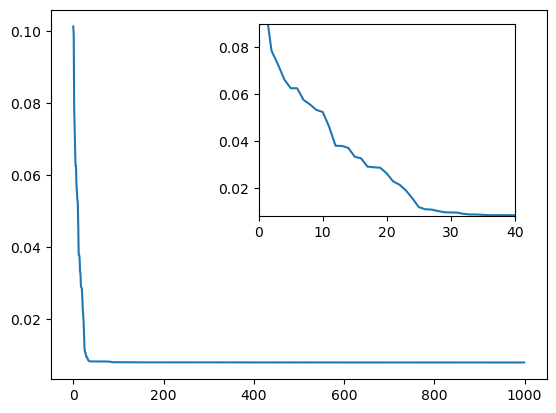

In [22]:
'''
Grafica para observar el descenso de fitness en los diversos datasets
'''
plt.plot(descensoFitnessLaser[1:])
# Crear un segundo conjunto de ejes para la segunda gráfica
ax = plt.axes([0.45, 0.45, 0.4, 0.4])  # [left, bottom, width, height]

# Graficar la segunda gráfica en los nuevos ejes
ax.plot(descensoFitnessLaser[1:])

# ax.set_xticks(np.arange(len(row)))
ax.set_ylim(0.008, 0.09)
ax.set_xlim(0,40)

plt.show()

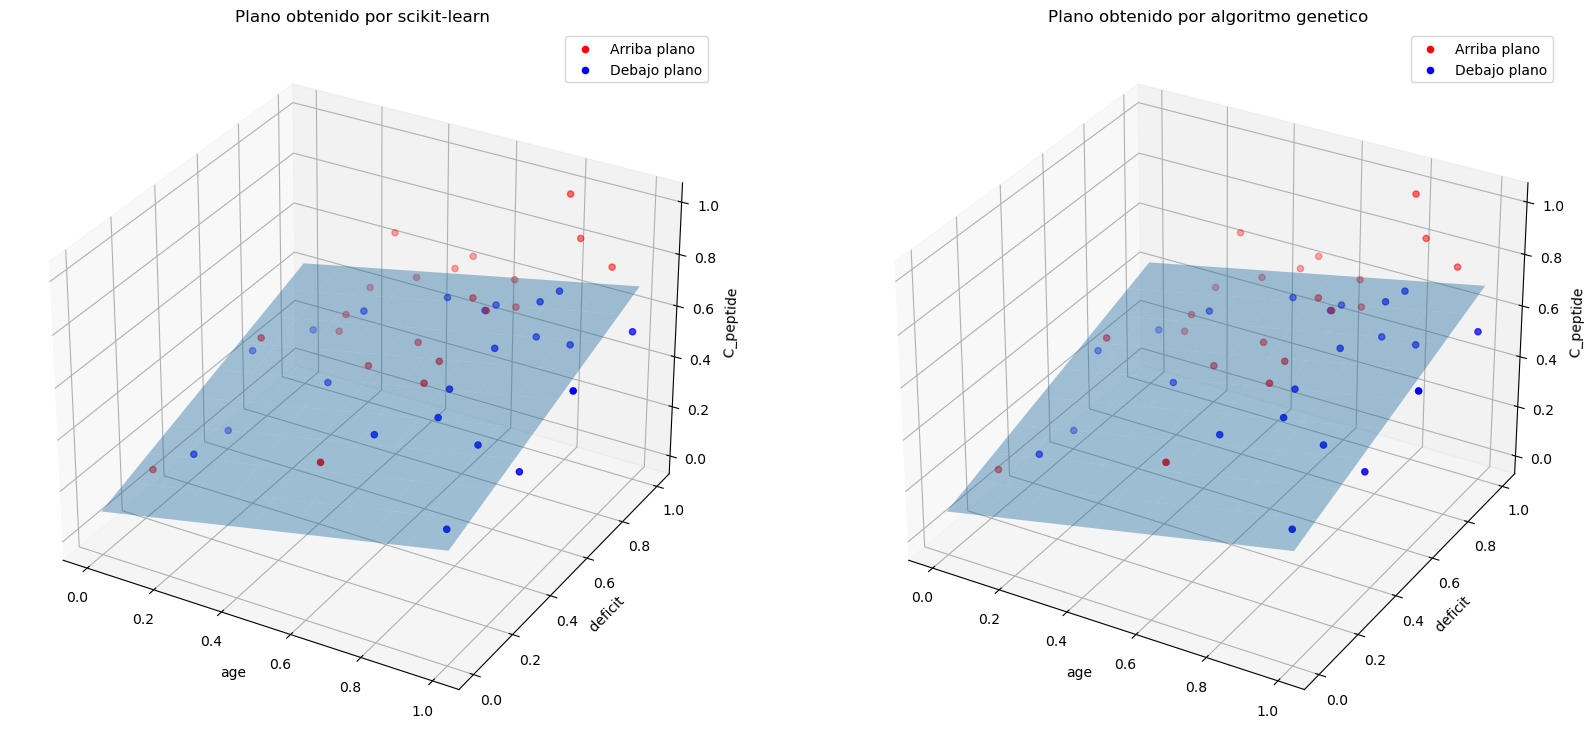

In [140]:
compararResultadosConScikit(X,y,poblacion[np.argmin(fitnes)],columnasDiabetes)